In [1]:
import pandas as pd
import os,sys
sys.path.append(os.path.expanduser("~") + "/growingentourage")
from geometry import *
sys.path.append("/Users/damoncrockett/ivpy/src")
from ivpy import *
from ivpy.extract import norm
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_pickle('/Users/damoncrockett/lmlproc/dbdf.pkl')

In [3]:
df[['tnorm','gnorm','rnorm','cnorm']] = norm(df[['thickness','g60','roughness','dmin']])

In [4]:
df.gnorm = df.gnorm.apply(lambda x: 1-x)

In [5]:
df['expressiveness'] = df.tnorm + df.gnorm + df.rnorm + df.cnorm

In [6]:
len(df.loc[df[['thickness', 'g60', 'roughness', 'dmin']].isnull().all(axis=1)])

388

# Bin edges

In [7]:
thickness = [0, 0.219, 0.399, 0.549, 1]
gloss = [0, 19, 34, 71, 86, 101, 210]
color = [-8, -0.02, 6.6, 11.97, 15.19, 22.98, 28.44, 37.31, 42]
roughness = [0, 0.013, 0.03, 0.04, 0.055, 0.098, 0.116, 0.142, 0.18, 0.305, 0.4]
expressiveness = [0, 1.3, 1.55, 1.85, 2.3, 2.6, 3, 4]

In [8]:
df['tbins'] = pd.cut(df.thickness,bins=thickness,right=True,labels=False)
df['gbins'] = pd.cut(df.g60,bins=gloss,right=True,labels=False)
df['cbins'] = pd.cut(df.dmin,bins=color,right=True,labels=False)
df['xbins'] = pd.cut(df.roughness,bins=roughness,right=True,labels=False)
df['ebins'] = pd.cut(df.expressiveness,bins=expressiveness,right=True,labels=False)

In [9]:
fullrows = df.loc[df[['thickness', 'g60', 'roughness', 'dmin']].notnull().all(axis=1)].index

In [10]:
def get_radar_group(df,i):
    try:
        t = int(df.tbins.loc[i])
        g = int(df.gbins.loc[i])
        c = int(df.cbins.loc[i])
        x = int(df.xbins.loc[i])

        return f'{t}_{g}_{c}_{x}'
    except:
        return None

In [11]:
df['radarGroup'] = [get_radar_group(df,i) for i in df.index]

# GEP

In [32]:
clusterable = df.loc[df.radarGroup.notnull()].index
featcols = ['tnorm','gnorm','rnorm','cnorm']
clustercol = 'radarGroup'

plotting_frame, cluster_groups, centroids = get_plotting_frame(df.loc[clusterable], featcols, clustercol)

In [49]:
subspace = get_subspace(centroids, cluster_groups)

In [74]:
subspace = bin_subspace(subspace, cluster_groups, spread_factor = 3)

In [75]:
pts = grow_entourages(plotting_frame, subspace)

plotting_frame['x'] = [item[0] for item in pts]
plotting_frame['y'] = [item[1] for item in pts]

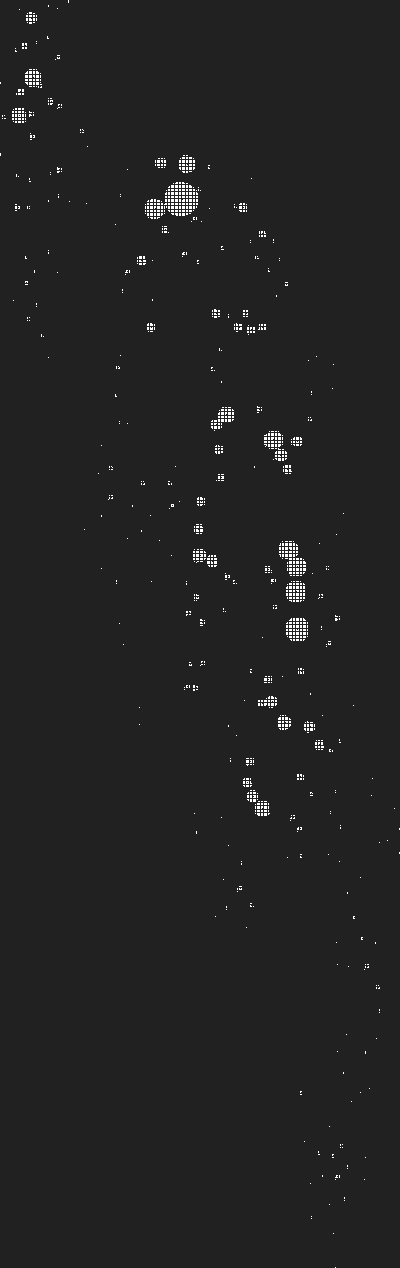

In [76]:
imagecol = 'cluster'

attach(plotting_frame, imagecol)

xrange = plotting_frame.x.max() - plotting_frame.x.min()
yrange = plotting_frame.y.max() - plotting_frame.y.min()

smaller_side = 400
side_ratio = max(xrange,yrange) / min(xrange,yrange)
larger_side = int(smaller_side * side_ratio)
if xrange > yrange:
    side1 = larger_side
    side2 = smaller_side
else:
    side2 = larger_side
    side1 = smaller_side

scatter('x','y',dot=True,thumb=1,side=(side1,side2)) 

In [77]:
df['gep300'] = plotting_frame.apply(lambda row: [row['y'], row['x']], axis=1)

In [78]:
df.to_pickle('/Users/damoncrockett/lmlproc/dbdfgep.pkl')